In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import entropy

In [2]:
sns.set_theme()

In [3]:
def plot_policy_distribution(policy_distribution: np.ndarray, agents: int, actions: int) -> None:
    """
    Plots the policy distribution for each agent and action.
    
    Args:
        policy_distribution (np.ndarray): The policy distribution for each agent and action.
        agents (int): The number of agents.
        actions (int): The number of actions.
    """
    fig, axes = plt.subplots(nrows=agents, ncols=actions, figsize=(12, 10))
    fig.suptitle('Policy Distribution')

    for agent_idx in range(agents):
        for action in range(actions):
            ax = axes[agent_idx, action]
            # Skip if action is not available
            if action >= policy_distribution[agent_idx].shape[0]:
                ax.set_visible(False)
                continue

            # Extract data for the current agent and action
            data = policy_distribution[agent_idx][action]  # Shape (2000, 5)
            timesteps = data.shape[1]  # Number of timesteps (e.g., 5)

            # Loop through each timestep and normalize histogram for each one
            for t in range(timesteps):
                timestep_data = data[:, t]  # Data for the specific timestep
                counts, bin_edges = np.histogram(timestep_data, bins=30, range=(-1, 1))
                counts = counts / counts.sum() * 100  # Normalize to get percentages

                # Plot the normalized histogram as a bar plot
                ax.bar(bin_edges[:-1], counts, width=(bin_edges[1] - bin_edges[0]), alpha=0.8, label=t)

            ax.set_title(f'Agent {agent_idx} - Action {action}')
            ax.legend()
            ax.set_xlabel('Action')
            ax.set_ylim(0, 100)
            ax.set_ylabel('Percentage')
            ax.set_xlim(-1, 1)

    plt.tight_layout()
    plt.show()

In [4]:
def calculate_kl_divergence(policy_distribution: np.ndarray, agents: int, actions: int) -> list:
    """
    Calculates the KL divergence between consecutive timesteps for each agent and action.
    
    Args:
        policy_distribution (np.ndarray): The policy distribution for each agent and action.
        agents (int): The number of agents.
        actions (int): The number of actions.
        
    Returns:
        kl_divergences (list): The KL divergence between consecutive timesteps for each agent and action.
    """
    kl_divergences = []

    for agent_idx in range(agents):
        agent_kl_divergences = []
        for action in range(actions):
            # Skip if action is not available
            if action >= policy_distribution[agent_idx].shape[0]:
                continue
            
            # Extract data and set up distributions for KL calculations
            data = policy_distribution[agent_idx][action]
            timesteps = data.shape[1]
            
            # Calculate histograms for each timestep and normalize
            timestep_distributions = []
            for t in range(timesteps):
                timestep_data = data[:, t]
                counts, _ = np.histogram(timestep_data, bins=30, range=(-1, 1))
                prob_dist = counts / counts.sum()  # Normalize to make it a probability distribution
                timestep_distributions.append(prob_dist + 1e-10)  # Add small value to avoid log(0)

            # Compute KL divergence between consecutive timesteps
            timestep_kl_divergences = []
            for t in range(1, timesteps):
                kl_div = entropy(timestep_distributions[t], timestep_distributions[t - 1])
                timestep_kl_divergences.append(kl_div)
            
            agent_kl_divergences.append(timestep_kl_divergences)
        kl_divergences.append(agent_kl_divergences)
    return kl_divergences

In [5]:
def normalize_kl_divergence(kl_divergences: np.ndarray) -> np.ndarray:
    """
    Normalizes the KL divergences for each agent, action, and timestep.
    
    Args:
        kl_divergences (np.ndarray): The KL divergences for each agent and action.
        
    Returns:
        normalized_kl_divergences (np.ndarray): The normalized KL divergences for each agent and action.
    """
    # Flatten all KL divergences into a 1D array to find the maximum KL divergence
    all_kl_values = [kl for agent_kl in kl_divergences for action_kl in agent_kl for kl in action_kl]
    max_kl = np.max(all_kl_values)

    # Normalize KL divergences for each agent, action, and timestep
    normalized_kl_divergences = []
    for agent_kl in kl_divergences:
        agent_normalized = []
        for action_kl in agent_kl:
            agent_normalized.append([kl / max_kl for kl in action_kl])
        normalized_kl_divergences.append(agent_normalized)
    return normalized_kl_divergences

In [6]:
def plot_kl_divergence(policy_distribution: np.ndarray, agents: int, actions: int) -> None:
    """
    Plots the KL divergences between consecutive timesteps for each agent and action.
    
    Args:
        policy_distribution (np.ndarray): The policy distribution for each agent and action.
        agents (int): The number of agents.
        actions (int): The number of actions.
    """
    fig, axes = plt.subplots(nrows=agents, ncols=actions, figsize=(12, 8))
    fig.suptitle('KL Divergences Between Consecutive Timesteps for Each Agent and Action')
    
    kl_divergences = calculate_kl_divergence(policy_distribution, agents, actions)
    normalized_kl_divergences = normalize_kl_divergence(kl_divergences)

    for agent_idx in range(agents):
        for action in range(actions):
            ax = axes[agent_idx, action]
            # Skip if action is not available
            if action >= policy_distribution[agent_idx].shape[0]:
                ax.set_visible(False)
                continue

            # Plot KL divergences for each timestep
            ax.plot(np.arange(1, 5), normalized_kl_divergences[agent_idx][action], marker='o')
            ax.set_title(f'Agent {agent_idx} - Action {action}')
            ax.set_xlabel('Timestep')
            ax.set_xlim(0.8, 4.2)
            ax.set_ylabel('Normalized KL Divergence')
            ax.set_ylim(-0.1, 1.1)
            
    plt.tight_layout()
    plt.show()

In [7]:
def plot_statistics(policy_distribution_path: str) -> None:
    """
    Plots the policy distribution and KL divergences for each agent and action.
    
    Args:
        policy_distribution_path (str): The path to the policy distribution file.
    """
    policy_distribution = np.load(policy_distribution_path, allow_pickle=True)
    agents = policy_distribution.shape[0]
    actions = max([policy_distribution[agent_idx].shape[0] for agent_idx in range(agents)])
    plot_policy_distribution(policy_distribution, agents, actions)
    plot_kl_divergence(policy_distribution, agents, actions)

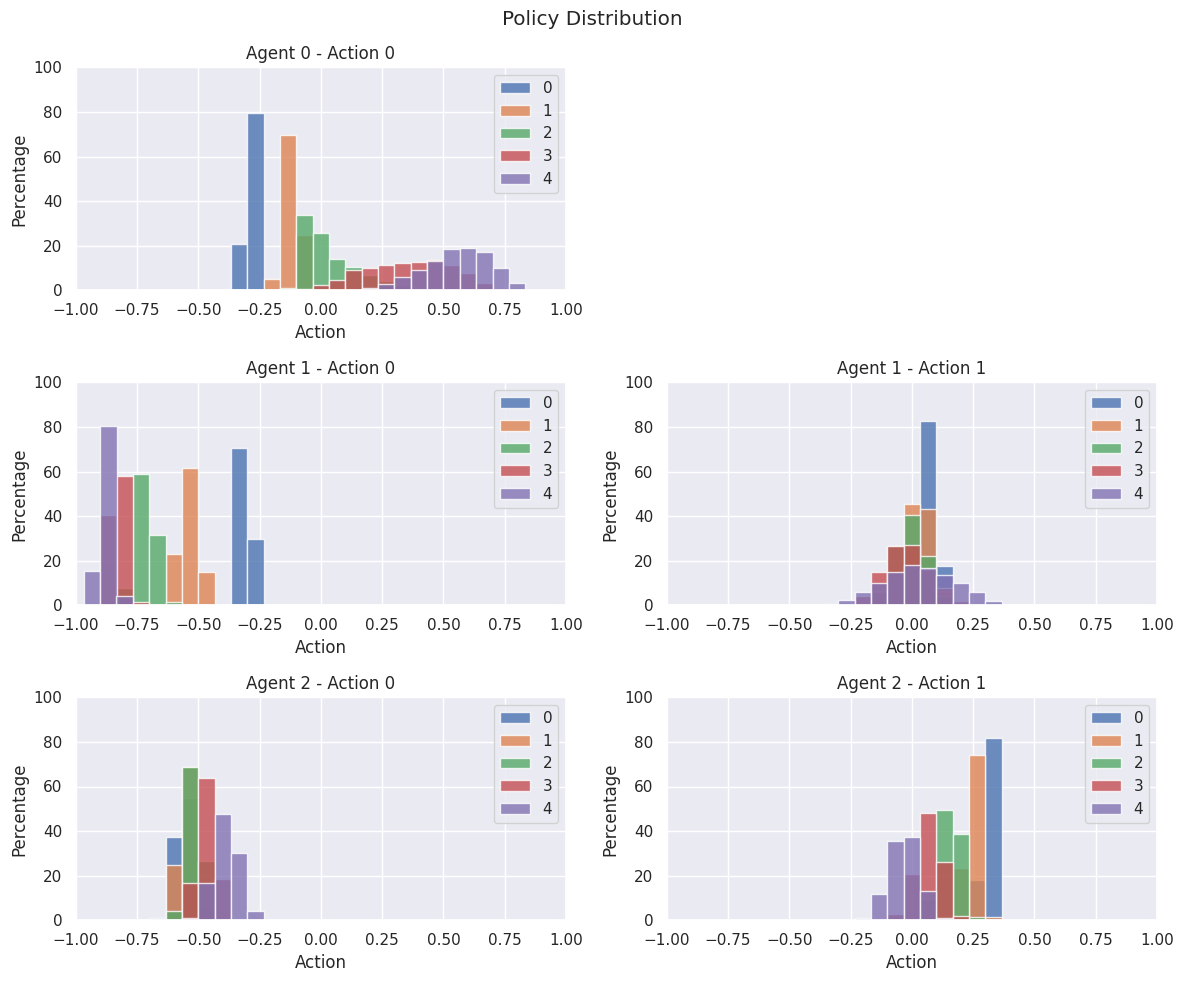

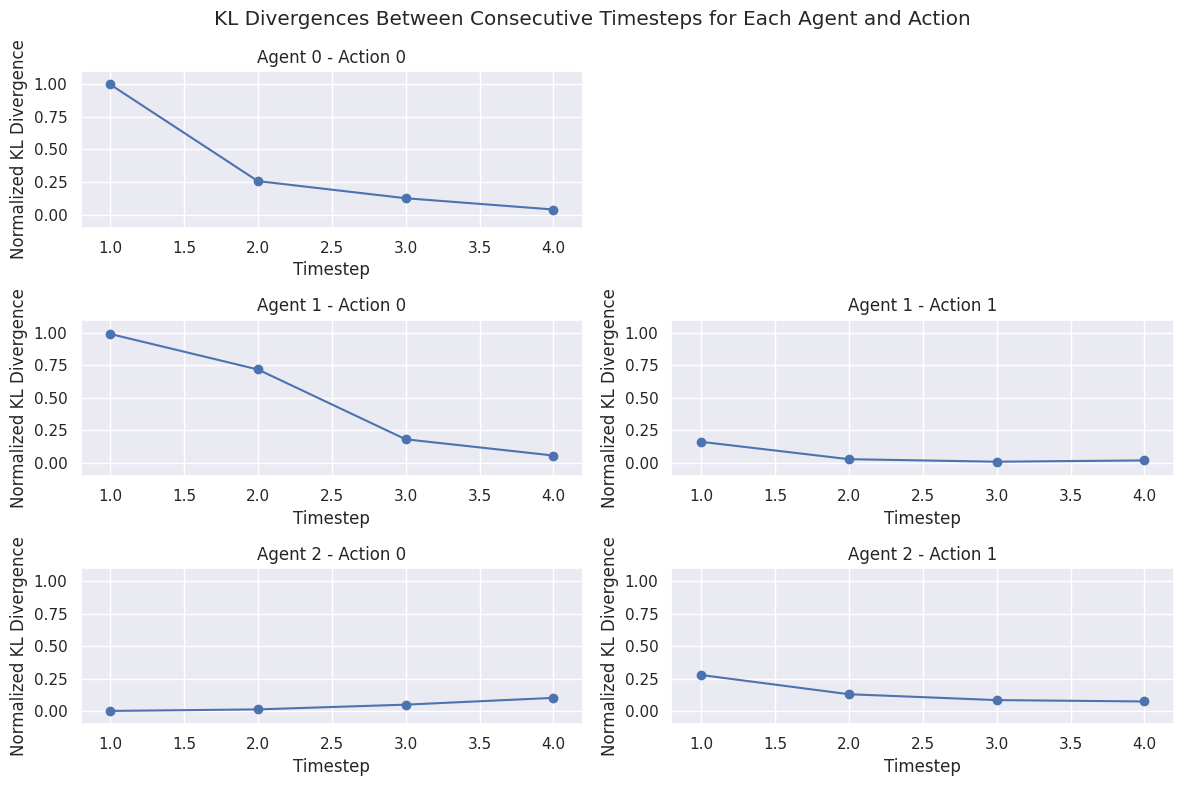

In [8]:
policy_distribution_path = '../models/policy/iql_sac/0/121124-120532/evaluation/policy_distribution.npy'
plot_statistics(policy_distribution_path)

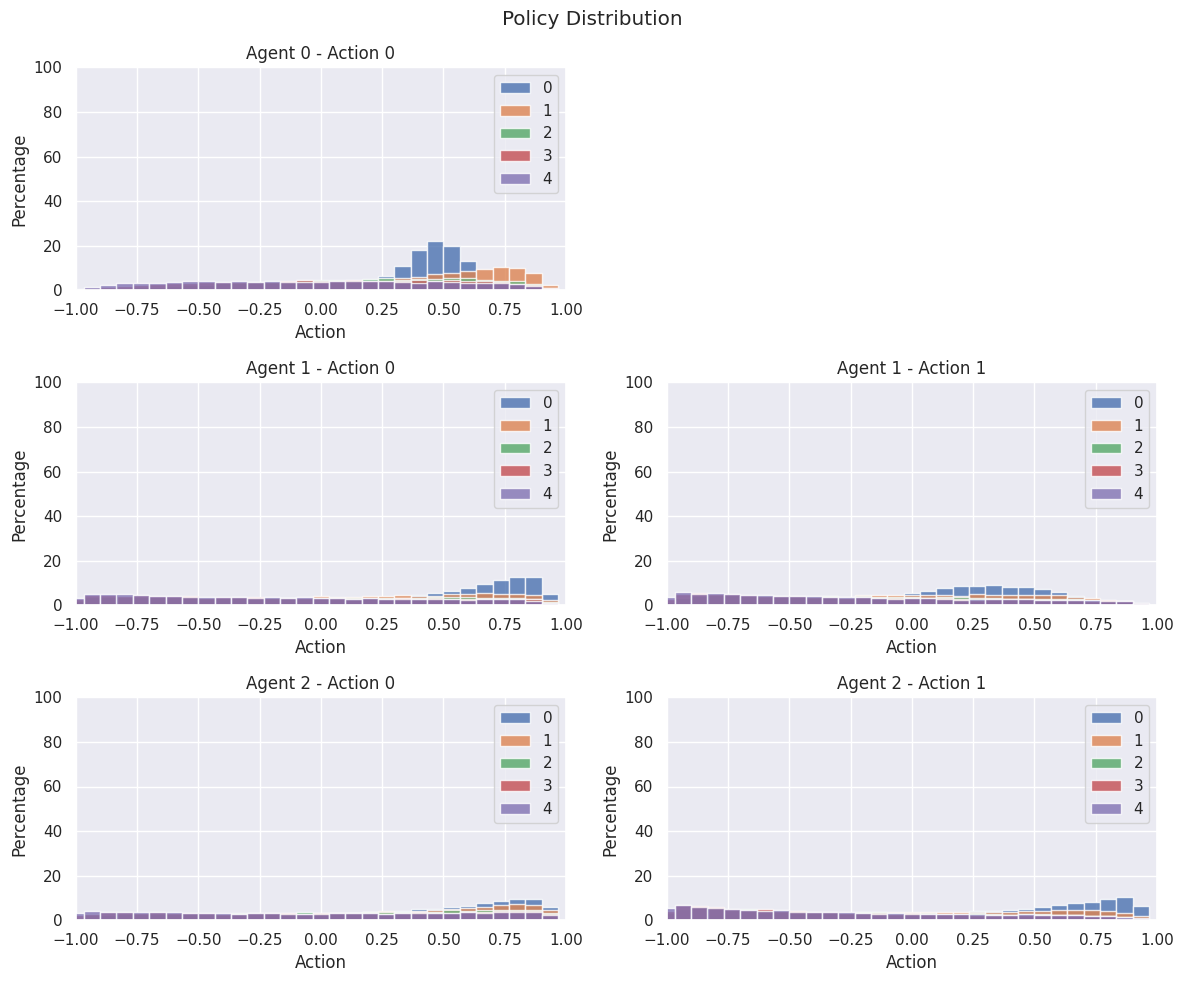

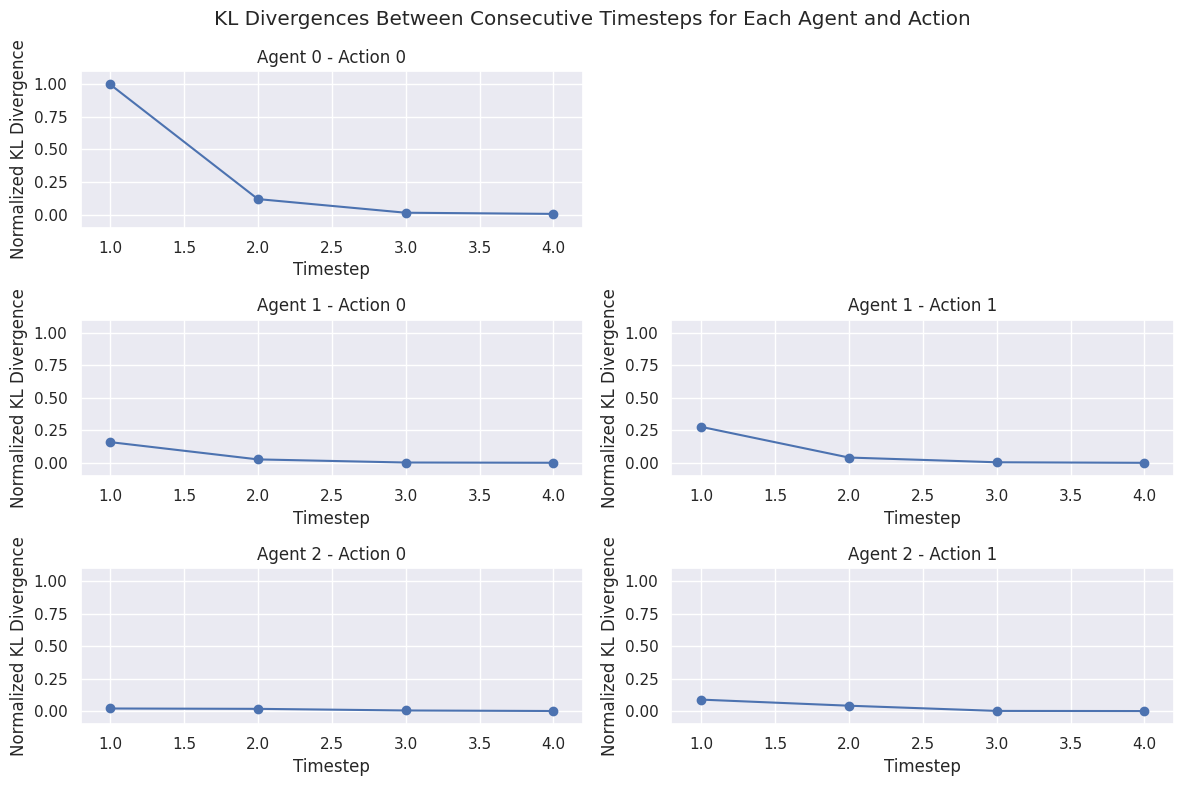

In [9]:
policy_distribution_path = '../models/policy/iql_sac/0/131124-120151/evaluation/policy_distribution.npy'
plot_statistics(policy_distribution_path)

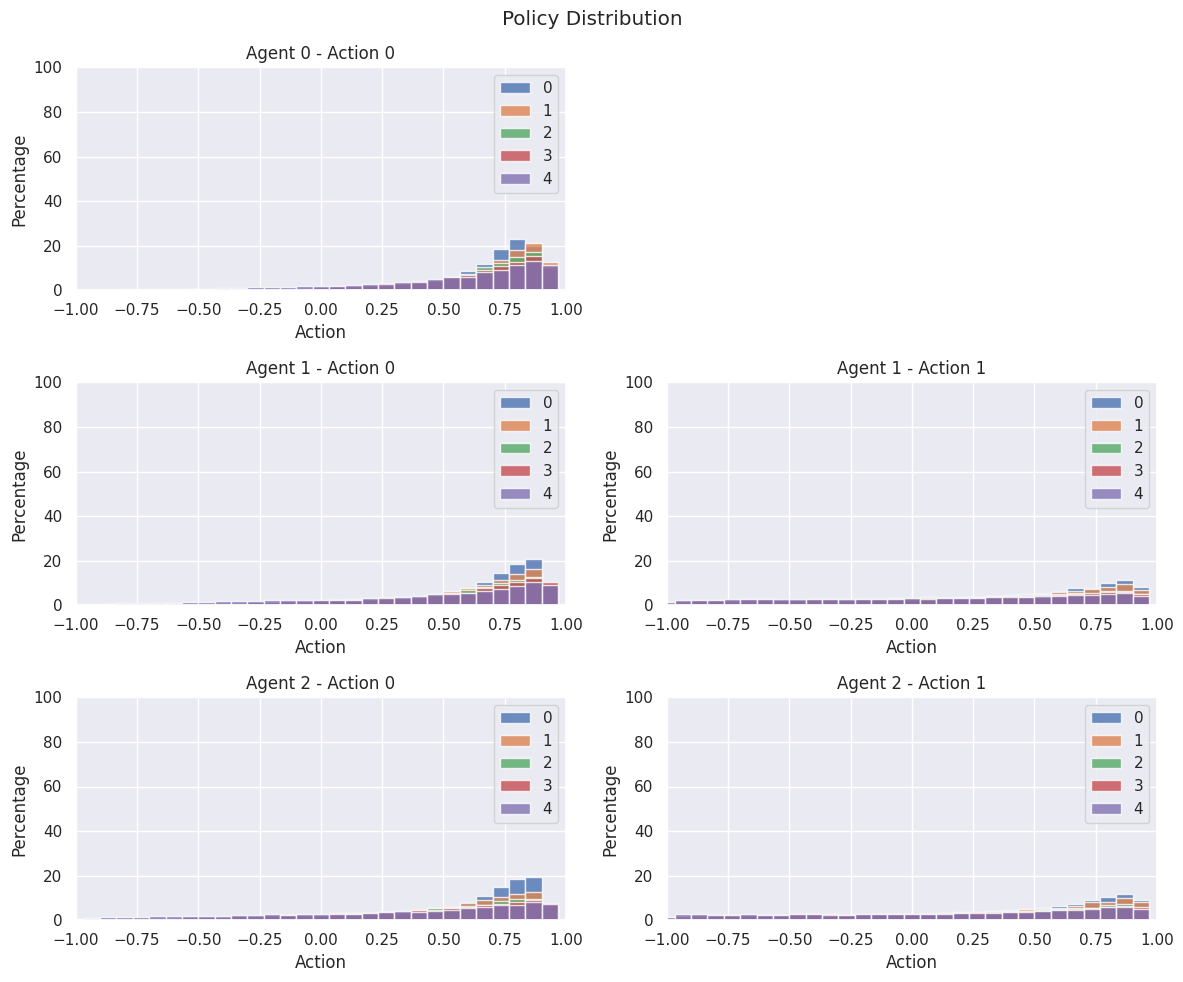

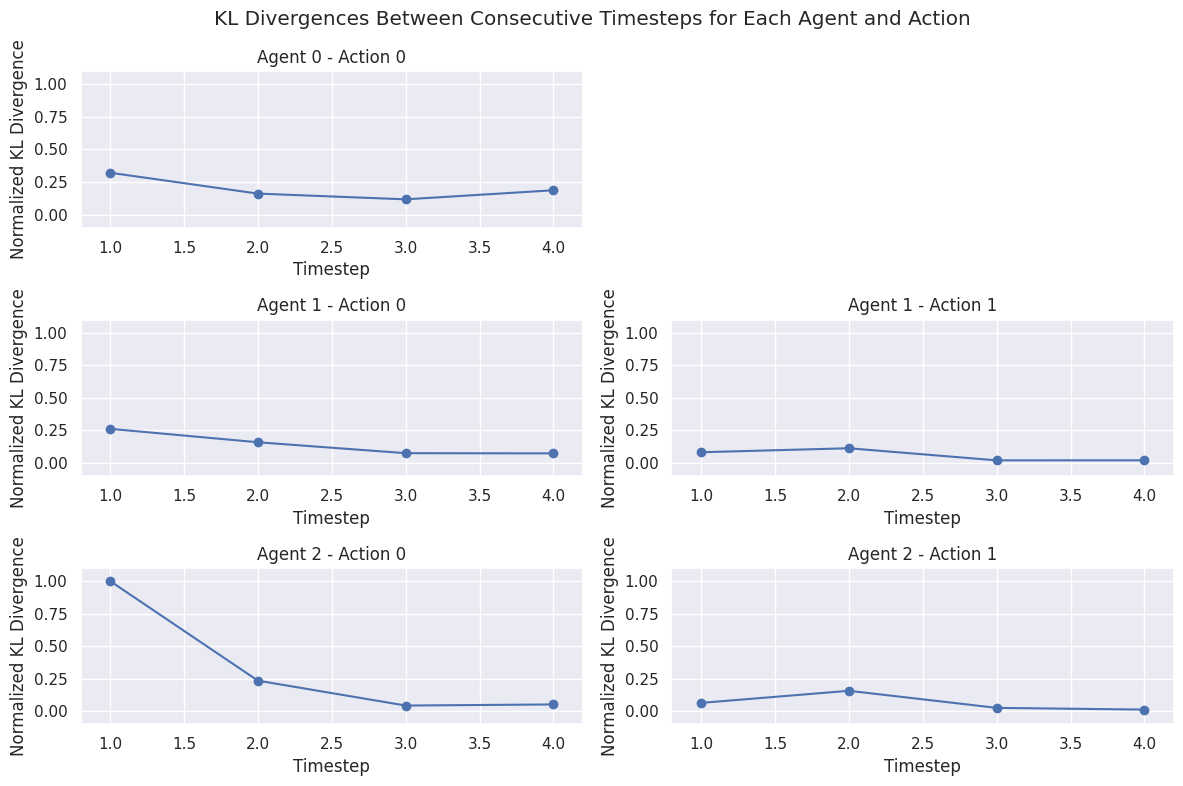

In [10]:
policy_distribution_path = '../models/policy/vdn/0/131124-133122/evaluation/policy_distribution.npy'
plot_statistics(policy_distribution_path)

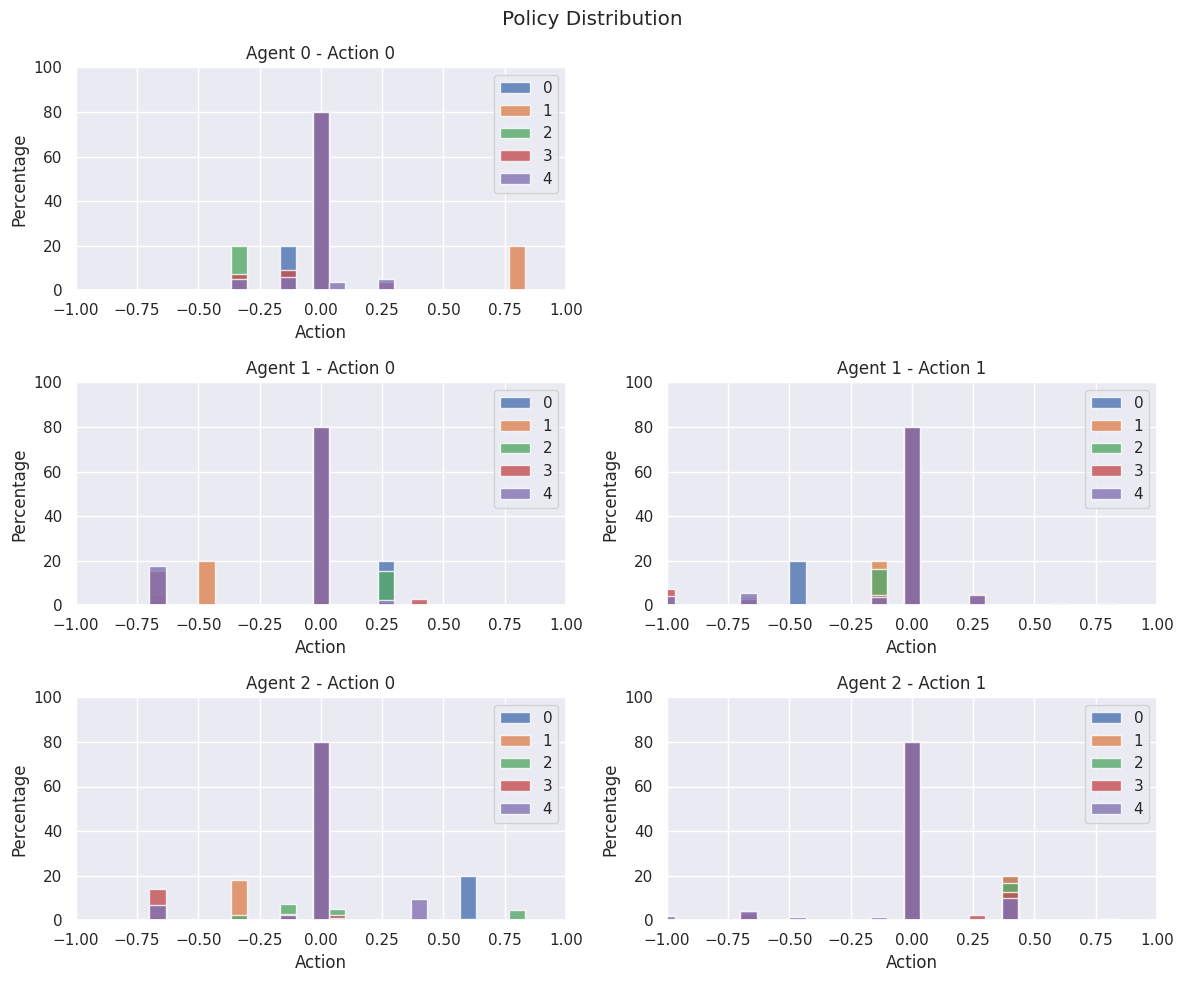

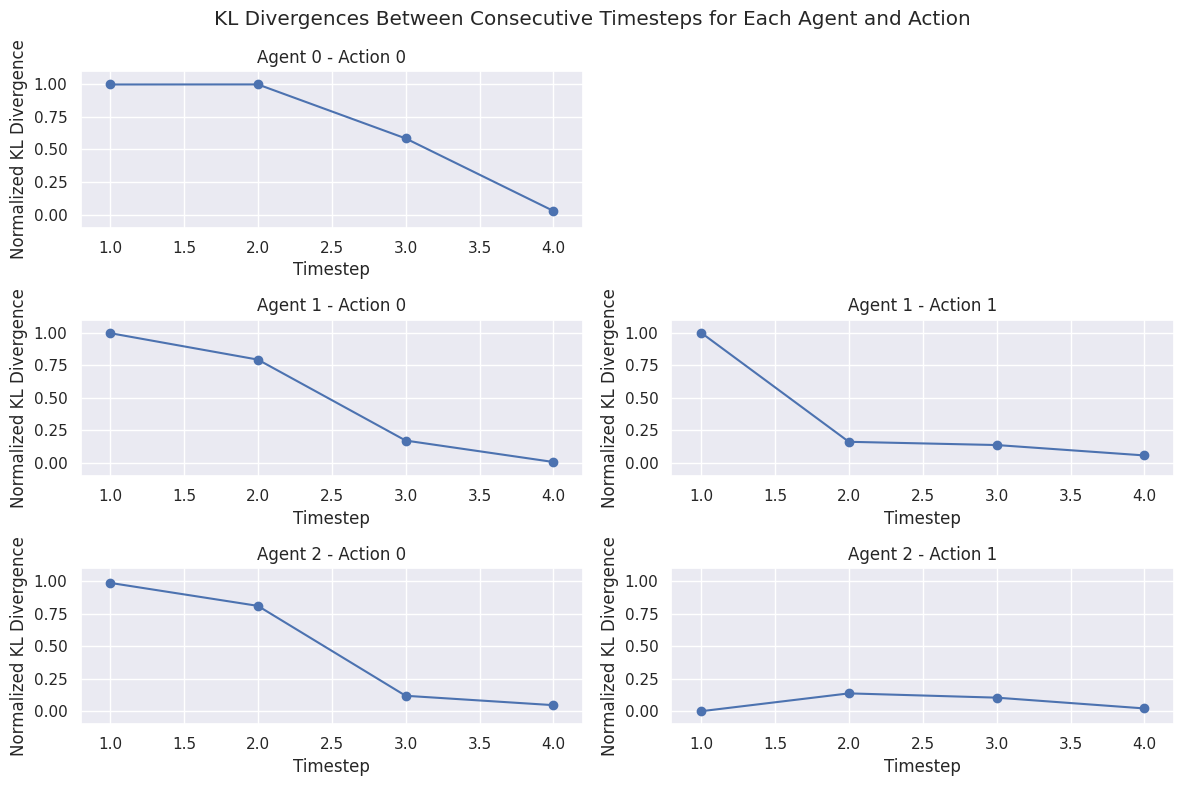

In [11]:
plot_statistics('/home/kinrre/Documentos/maac/models/policy/maac/0/131124-201918/evaluation/policy_distribution.npy')